# Advanced Lane Finding

## Overview

This notebook contains an implementation to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are located in this [repository](https://github.com/abmantha/CarND-Advanced-Lane-Lines.git)

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Imports

In [1]:
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Load Test Images

In [2]:
test_images_paths = ["test_images/test*.jpg"]
test_images = glob.glob(test_images_paths[0])

straight_line_test_paths = ["test_images/straight_line*.jpg"]
straight_line_test_images = glob.glob(straight_line_test_paths[0])

hood_test_paths = ["test_images/hood-test*.jpg"]
hood_test_images = glob.glob(hood_test_paths[0])

calibration_images_paths = ["camera_cal/calibration*.jpg"]
calibration_images = glob.glob(calibration_images_paths[0])

anomaly_images = glob.glob("test_images/anomaly*.jpg")

## 1. Camera Calibration

### Finding Chessboard Corners

In [3]:
# Create objpoints and imgpoints data from calibration images
%matplotlib qt
%matplotlib inline

nx = 9
ny = 6

def get_calibration_points(images): 
    objpoints = [] # Known object coordinates for chessboard
    imgpoints = []

    objp = np.zeros((ny*nx,3), np.float32) 
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

###################### FOR PLOTTING PURPOSES ONLY #######################
#     figure, axis = plt.subplots(5, 4, figsize=(16, 16))
#     figure.subplots_adjust(hspace=0.4, wspace=0.3)
#     axis = axis.ravel()
################################ END ####################################


    for index, fname in enumerate(images):
        # Read in a new image
        img = mpimg.imread(fname)
        
        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If corners are found, add object points, image points
        if ret == True: 
            imgpoints.append(corners)
            objpoints.append(objp)
            img_with_chessboard = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            
###################### FOR PLOTTING PURPOSES ONLY #######################
#             axis[index].set_title(fname)
#             axis[index].axis('off')
#             axis[index].imshow(img_with_chessboard)
################################ END ####################################
            
    return objpoints, imgpoints

objpoints, imgpoints = get_calibration_points(calibration_images)

## 2. Distortion Correction

### Utility Functions

In [4]:
# Only need to apply this to a single image to retrieve calibration values
def get_camera_calibration_matrices(image, objpoints, imgpoints): 
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)
    return mtx, dist

# Apply this to each image when undistortion
def undistort(image): 
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    return undistort

### Example of Undistortion on Calibration Image

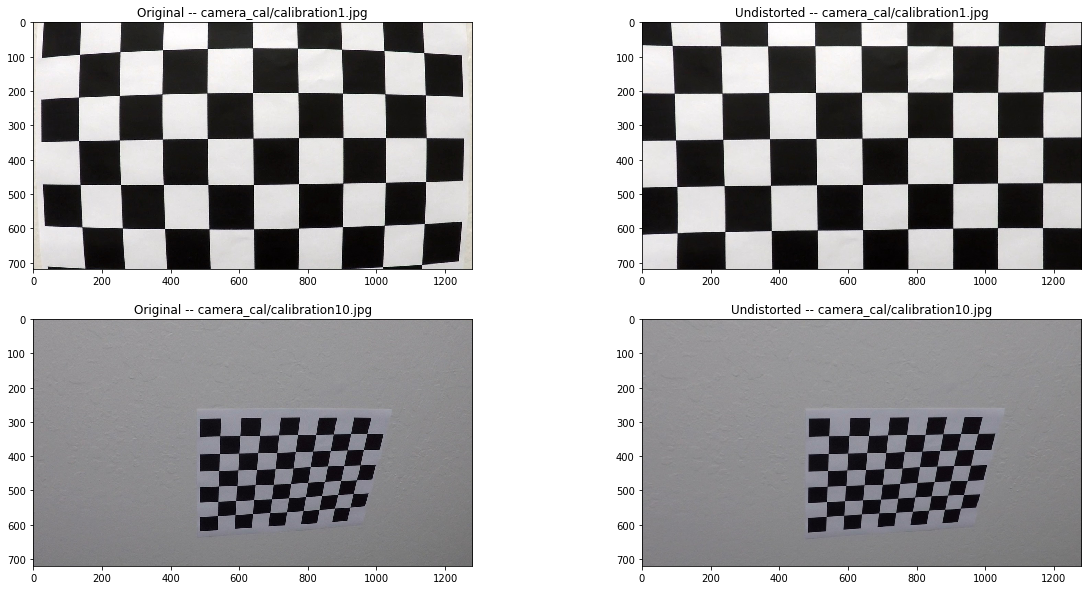

In [5]:
filename_1 = calibration_images[0]
filename_2 = calibration_images[1]
calibration_image = mpimg.imread(filename_1)
calibration_image_2 = mpimg.imread(filename_2)
mtx, dist = get_camera_calibration_matrices(calibration_image, objpoints, imgpoints)

undistorted_calibration_image = undistort(calibration_image)
undistorted_calibration_image_2 = undistort(calibration_image_2)

figure, axis = plt.subplots(2, 2, figsize=(20, 10))
axis = axis.ravel()
axis[0].imshow(calibration_image)
axis[0].set_title("Original -- " + filename_1)

axis[1].imshow(undistorted_calibration_image)
axis[1].set_title("Undistorted -- " + filename_1)

axis[2].imshow(calibration_image_2)
axis[2].set_title("Original -- " + filename_2)

axis[3].imshow(undistorted_calibration_image_2)
axis[3].set_title("Undistorted -- " + filename_2)

figure.savefig("output_images/example_undistorted_calibration_images.png")

### Undistortion of Test Images

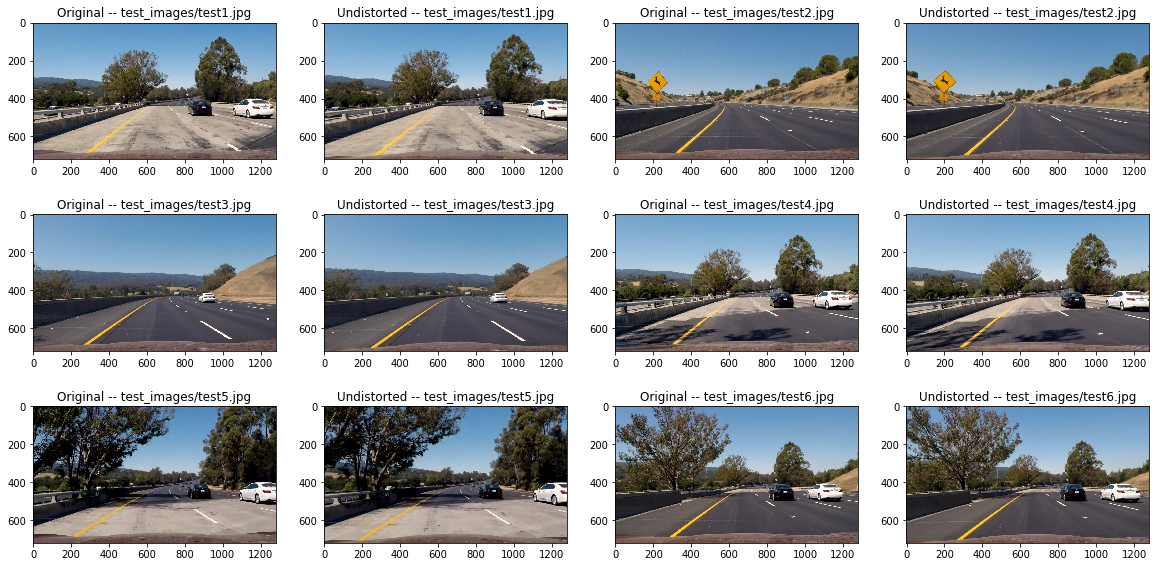

In [6]:
figure, axis = plt.subplots(3, 4, figsize=(20, 10))
axis = axis.ravel()
index = 0

for i, fname in enumerate(test_images):
    test_image = mpimg.imread(fname)
    undistorted_test_image = undistort(test_image)
    axis[index].set_title("Original -- " + fname)
    axis[index].imshow(test_image)
    axis[index+1].set_title("Undistorted -- " + fname)
    axis[index+1].imshow(undistorted_test_image)
    index += 2
    
figure.savefig("output_images/example_undistorted_test_images.png")

## 3. Perspective Transform

In [7]:
def warp(image, src, dest): 
    # Get the transform matrix and inverse
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)

    # Apply transform matrix to produce perspective-transformed image
    warped_image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

    return warped_image, M, Minv

### Identify source and destination points on test images

In [8]:
def plot_warped_images(image_list, figure, axis, out_fname): 
    index = 0
    for fname in image_list: 
        test_image = mpimg.imread(fname)
        undistorted_test_image = undistort(test_image)
        image_size = undistorted_test_image.shape
        
        # define source and destination points for transform    
        src = np.float32([(570,470), (750,470), (200,680), (1157,680)])
        dest = np.float32([(250,0), (1100,0), (250,720), (1100,720)])

        warped_test_image, M, Minv = warp(undistorted_test_image, src, dest)

        axis[index].set_title("Original")
        axis[index].imshow(test_image)

        axis[index+1].set_title("Undistorted Original")
        axis[index+1].imshow(undistorted_test_image)
        
        x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
        y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
        axis[index+1].plot(x, y)

        axis[index+2].set_title("Warped")
        axis[index+2].imshow(warped_test_image)
        
        warp_x = [dest[0][0], dest[2][0], dest[3][0], dest[1][0], dest[0][0]]
        warp_y = [dest[0][1], dest[2][1], dest[3][1], dest[1][1], dest[0][1]] 
        axis[index+2].plot(warp_x, warp_y)
        index += 3
        
    figure.savefig(out_fname)

### Plot warped test images

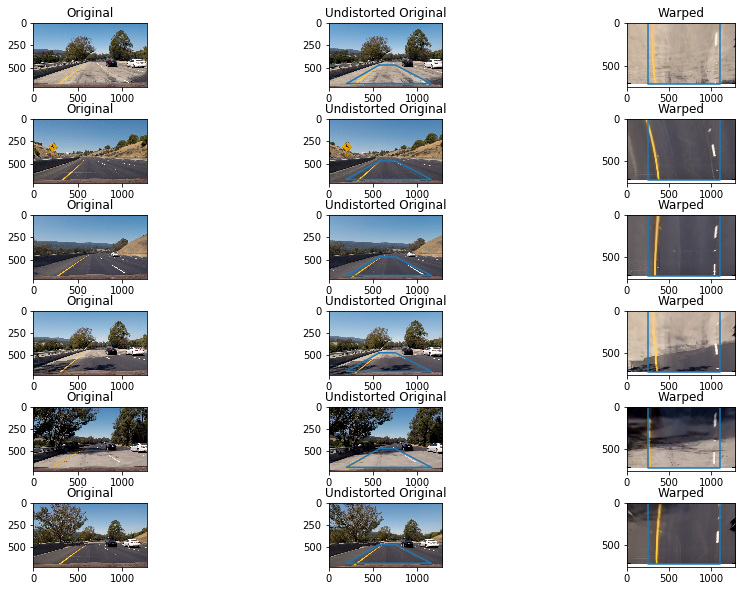

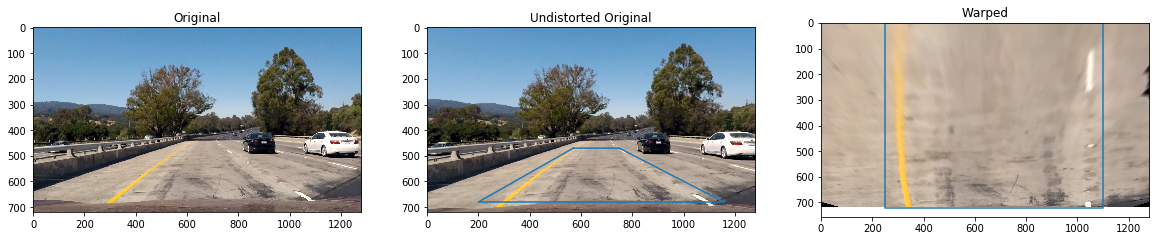

In [9]:
figure, axis = plt.subplots(6, 3, figsize=(15, 10))
figure.subplots_adjust(hspace=0.5)
axis = axis.ravel()    
    
plot_warped_images(test_images, figure, axis, "output_images/example_undistorted_warped_test_images.png")

figure2, axis2 = plt.subplots(1, 3, figsize=(20, 5))
axis2 = axis2.ravel()
plot_warped_images(test_images[:1], figure2, axis2, "output_images/example_undistorted_warped_test_image_single.png")

## 4. Color/Gradient Thresholding

In [10]:
def abs_sobel_threshold(image, orient='x', sobel_kernel=3, threshold=(0, 255)): 
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient='x' or 'y'
    xorder = 1 if orient == 'x' else 0
    sobel = cv2.Sobel(gray, cv2.CV_64F, xorder, not xorder, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then conver to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude is > threshold[0] and < threshold[1]
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    
    return binary_output

def magnitude_threshold(image, sobel_kernel=3, threshold=(0, 255)): 
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x and y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    sobel_x2 = np.square(sobel_x)
    sobel_y2 = np.square(sobel_y)
    abs_sobel_xy = np.sqrt(sobel_x2 + sobel_y2)
    
    # 4) Scale to 8-bit (0 - 255) then conver to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel_xy / np.max(abs_sobel_xy))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude is > threshold[0] and < threshold[1]
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    
    return binary_output
 

def direction_threshold(image, sobel_kernel=3, threshold=(0, np.pi/2)): 
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x and y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute x and y gradients
    abs_sobel_x = np.square(sobel_x)
    abs_sobel_y = np.square(sobel_y)
    
    # 4) Calculate the direction of gradient
    dir_sobel = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude is > threshold[0] and < threshold[1]
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= threshold[0]) & (dir_sobel <= threshold[1])] = 1
    
    return binary_output

def binary_color_threshold(image, flag, c, threshold): 
    color_space = cv2.cvtColor(image, flag)
    channel = color_space[:, :, c]
    binary_color_space = np.zeros_like(channel)
    binary_color_space[(channel >= threshold[0]) & (channel <= threshold[1])] = 1
    return binary_color_space

### Thresholding Plotting Utilities

In [11]:
def generate_color_gradient_threshold_plot(image_fname, axis, index, ret=False):
        raw_image = mpimg.imread(image_fname)

        # Undistortion
        raw_image_undistorted = undistort(raw_image)
        img_shape = raw_image_undistorted.shape

        # Source and destination points for transform

    
        src = np.float32([(570,470), (750,470), (200,680), (1157,680)])
        dest = np.float32([(300,0), (1100,0), (300,720), (1100,720)])

        # Perspective transform
        raw_image_undistorted_warped, Mat, MatInv = warp(raw_image_undistorted, src, dest)

        # Color thresholding
        lab_binary_threshold = binary_color_threshold(raw_image_undistorted_warped, cv2.COLOR_RGB2Lab, 2, (145, 255))
        luv_binary_threshold = binary_color_threshold(raw_image_undistorted_warped, cv2.COLOR_RGB2Luv, 0, (207, 255))
        hls_binary_threshold = binary_color_threshold(raw_image_undistorted_warped, cv2.COLOR_RGB2HLS, 1, (200, 255))
        hsv_binary_threshold = binary_color_threshold(raw_image_undistorted_warped, cv2.COLOR_RGB2HSV, 2, (230, 255))
        combined_color_binary = cv2.bitwise_or(lab_binary_threshold, luv_binary_threshold)
    
        # Gradient thresholding
        sobel_binary_x = abs_sobel_threshold(raw_image_undistorted_warped, 'x', 3, (20, 100))
        sobel_binary_y = abs_sobel_threshold(raw_image_undistorted_warped, 'y', 3, (20, 100))
        sobel_binary_magnitude = magnitude_threshold(raw_image_undistorted_warped, 5, (20, 100))
        sobel_binary_direction = direction_threshold(raw_image_undistorted_warped, 17, (0.7, 1.3))

        # For color and gradient thresholding combinations
        combined_binary = np.zeros_like(sobel_binary_x)
        combined_binary[(sobel_binary_x == 1) | (combined_color_binary == 1)] = 1

        # Plots
        axis[index+0].set_title("Raw")
        axis[index+0].imshow(raw_image)

        axis[index+1].set_title("Undistort")
        axis[index+1].imshow(raw_image_undistorted)

        axis[index+2].set_title("Warped")
        axis[index+2].imshow(raw_image_undistorted_warped)
        
        axis[index+3].set_title("La(b)")
        axis[index+3].imshow(lab_binary_threshold, cmap='gray')
        
        axis[index+4].set_title("Lu(v)")
        axis[index+4].imshow(luv_binary_threshold, cmap='gray')

        axis[index+5].set_title("HLS(L)")
        axis[index+5].imshow(hls_binary_threshold, cmap='gray')

        axis[index+6].set_title("HS(V)")
        axis[index+6].imshow(hsv_binary_threshold, cmap='gray')     

        axis[index+7].set_title("Grad-X")
        axis[index+7].imshow(sobel_binary_x, cmap='gray')

        axis[index+8].set_title("Grad-Y")
        axis[index+8].imshow(sobel_binary_y, cmap='gray')

        axis[index+9].set_title("Grad-Mag")
        axis[index+9].imshow(sobel_binary_magnitude, cmap='gray')

        axis[index+10].set_title("Grad-Dir")
        axis[index+10].imshow(sobel_binary_direction, cmap='gray')

        axis[index+11].set_title("Color Combo")
        axis[index+11].imshow(combined_color_binary, cmap='gray')
        
        axis[index+12].set_title("Grad Combo")
        axis[index+12].imshow(combined_binary, cmap='gray')     
                
        if ret:
            return [raw_image, raw_image_undistorted, raw_image_undistorted_warped, combined_color_binary, Mat, MatInv]
        
def generate_color_gradient_threshold_grid(image_list, n):
    warped_and_thresholded = []
    f, axis = plt.subplots(n, 13, figsize=(20, 10))
    axis = axis.ravel()
    index = 0
    for fname_raw in image_list: 
        warped_and_thresholded.append(generate_color_gradient_threshold_plot(fname_raw, axis, index, ret=True))
        index += 13
    f.savefig("output_images/color_gradient_thresholding_plot.png")
    return warped_and_thresholded

### Generate Individual Plots

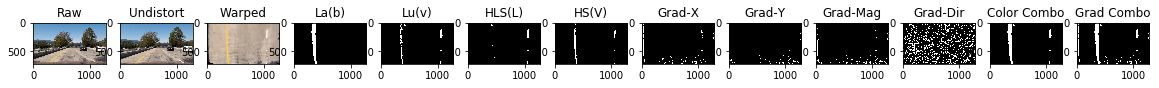

In [12]:
fig, axis = plt.subplots(1, 13, figsize=(20, 10))
axis = axis.ravel()
generate_color_gradient_threshold_plot(test_images[0], axis, 0)

### Generate Grid Plot 

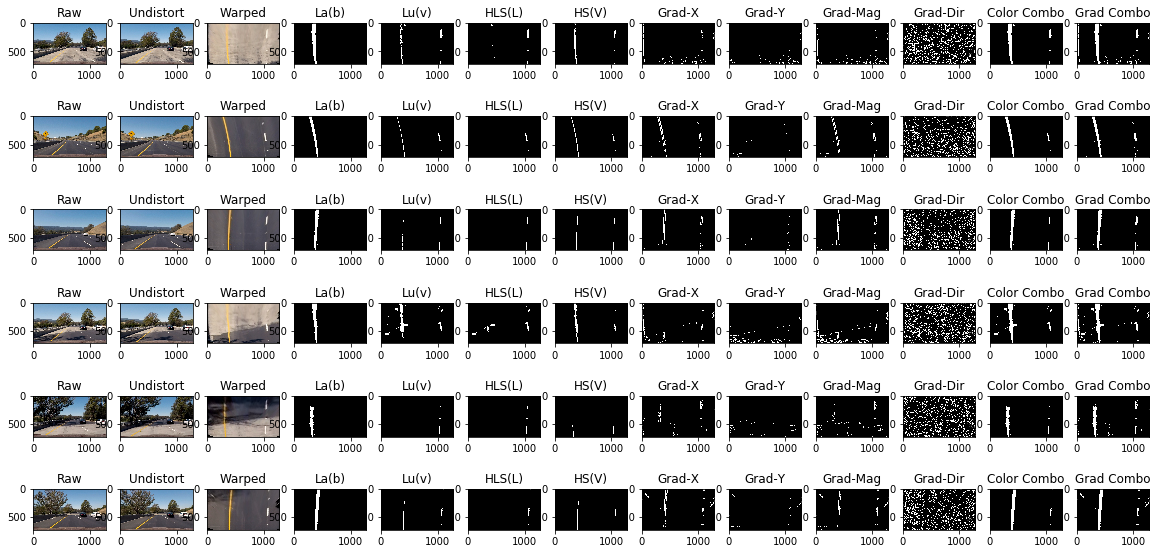

In [13]:
test_warped_and_thresholded = generate_color_gradient_threshold_grid(test_images, len(test_images))

## 5. Lane Finding: Sliding Window Search w/ Convolutions

In [16]:
def window_mask(width, height, image, center,level):
    output = np.zeros_like(image)
    output[int(image.shape[0]-(level+1)*height):int(image.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),image.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(5*image.shape[0]/12):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def single_image_convolution_search(window_width, window_height, margin, raw_image, binary_warped, Mat, MatInv):

    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        left_x = []
        right_x = [] 

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            left_x.append(window_centroids[level][0])
            right_x.append(window_centroids[level][1])

            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)

            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)),np.uint8) # making the original road pixels 3 color channels
        convolution_output_image = cv2.addWeighted(warpage, 1.0, template, 0.5, 0.0) # overlay the orignal road image with window results

     # If no window centers found, just display orginal road image
    else:
        convolution_output_image = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)

    yvals = range(0, binary_warped.shape[0])
    res_yvals = np.arange((binary_warped.shape[0] - (window_height) / 2), 0, -window_height)

    # Extrapolate x and y poly-fit lines
    left_fit = np.polyfit(res_yvals, left_x, 2)
    left_fit_x = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fit_x = np.array(left_fit_x, np.int32)

    right_fit = np.polyfit(res_yvals, right_x, 2)
    right_fit_x = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fit_x = np.array(right_fit_x, np.int32)
        
    left_lane = np.array(list(zip(np.concatenate((left_fit_x-window_width/2, left_fit_x[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0) )), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fit_x-window_width/2, right_fit_x[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0) )), np.int32)

    # Draw lane lines
    road = np.zeros_like(raw_image)
    cv2.fillPoly(road, [left_lane], color=[255, 0, 0])
    cv2.fillPoly(road, [right_lane], color=[0, 0, 255])
    road_warped = cv2.warpPerspective(road, MatInv, (raw_image.shape[1], raw_image.shape[0]), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(raw_image, 1.0, road_warped, 1.0, 0.0)

    # Calculate radius of curvature
    left_curve_rad, right_curve_rad = radius_of_curvature(res_yvals, left_x, right_x)
    average_curve_rad = (left_curve_rad + right_curve_rad) / 2
    
    # Calculate distance from center
    distance_from_center_in_meters = distance_from_center(binary_warped, left_fit_x, right_fit_x)

    # Draw radius of curvature and distance from center
    result = draw_road_data(result, average_curve_rad, distance_from_center_in_meters) 
    
    result = draw_lanes(result, binary_warped, MatInv, left_fit, right_fit)
        
    return result, convolution_output_image

### Measuring Radius of Curvature and Distance from Center

In [17]:
def radius_of_curvature(yvals, left_fit_x, right_fit_x):
    y_meters_per_pixel = 25 / 720
    x_meters_per_pixel = 3.7 / 800
    
    if len(left_fit_x) != 0 and len(right_fit_x) != 0:
        left_curve_fit_in_meters = np.polyfit(np.array(yvals, np.float32)*y_meters_per_pixel, np.array(left_fit_x, np.float32)*x_meters_per_pixel, 2)
        right_curve_fit_in_meters = np.polyfit(np.array(yvals, np.float32)*y_meters_per_pixel, np.array(right_fit_x, np.float32)*x_meters_per_pixel, 2)

        left_curve_rad = ((1 + (2*left_curve_fit_in_meters[0]*yvals[0]*y_meters_per_pixel + left_curve_fit_in_meters[1])**2)**1.5) / np.absolute(2*left_curve_fit_in_meters[0])
        right_curve_rad = ((1 + (2*right_curve_fit_in_meters[0]*yvals[0]*y_meters_per_pixel + right_curve_fit_in_meters[1])**2)**1.5) / np.absolute(2*right_curve_fit_in_meters[0])
        
        return left_curve_rad, right_curve_rad
    
    return (None, None)

def radius_of_curvature_2(image, left_fit_x, right_fit_x):
    ym_per_pix = 25 / 720
    xm_per_pix = 3.7 / 800
    
    plot_y = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(plot_y)
    
    if len(left_fit_x) != 0 and len(right_fit_x) != 0:
        left_fit_converted = np.polyfit(plot_y * ym_per_pix, left_fit_x * xm_per_pix, 2)
        right_fit_converted = np.polyfit(plot_y * ym_per_pix, right_fit_x * xm_per_pix, 2)

        left_curve_rad = ((1 + (2*left_fit_converted[0]*y_eval*ym_per_pix + left_fit_converted[1])**2)**1.5) / np.absolute(2*left_fit_converted[0])
        right_curve_rad = ((1 + (2*right_fit_converted[0]*y_eval*ym_per_pix + right_fit_converted[1])**2)**1.5) / np.absolute(2*right_fit_converted[0])

        return left_curve_rad, right_curve_rad

    return None, None

def distance_from_center(binary_warped, left_fit_x, right_fit_x): 
    y_meters_per_pixel = 25 / 720
    x_meters_per_pixel = 3.7 / 800
    
    if len(left_fit_x) != 0 and len(right_fit_x) != 0:         
        camera_center = binary_warped.shape[1] / 2
        
        lane_center = (left_fit_x[0] + right_fit_x[0]) / 2
        distance_from_center_in_meters = (lane_center - camera_center) * x_meters_per_pixel

        return distance_from_center_in_meters
    
    return None

### Pipeline Utilities

In [18]:
# Apply this to each image when undistortion
def undistort(image): 
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    return undistort

def threshold(image): 
    img_shape = image.shape
    
    lab_binary_threshold = binary_color_threshold(image, cv2.COLOR_RGB2Lab, 2, (145, 255))
    luv_binary_threshold = binary_color_threshold(image, cv2.COLOR_RGB2Luv, 0, (207, 255))    
    sobel_binary_x = abs_sobel_threshold(image, 'x', 3, (20, 100))

    combined_color_binary = cv2.bitwise_or(lab_binary_threshold, luv_binary_threshold)
    combined_binary = np.zeros_like(sobel_binary_x)
    combined_binary[(sobel_binary_x == 1) | (combined_color_binary == 1)] = 1

    return combined_color_binary

def warped(image, src, dest): 
    # Get the transform matrix and inverse
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)

    # Apply transform matrix to produce perspective-transformed image
    warped_image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

    return warped_image, M, Minv

def process_image(image): 
    # 1. Undistort
    undistorted = undistort(image)
    
    # 2. Warp
    # Source and destination points for transform
    src = np.float32([(570,470), (750,470), (200,680), (1157,680)])
    dest = np.float32([(250,0), (1100,0), (250,720), (1100,720)])
    warped_image, M, Minv = warped(undistorted, src, dest)
    
    # 3. Color/Gradient thresholding
    thresholded = threshold(warped_image)
    
    return undistorted, warped_image, thresholded, M, Minv

def window_mask(width, height, image, center,level):
    output = np.zeros_like(image)
    output[int(image.shape[0]-(level+1)*height):int(image.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),image.shape[1])] = 1
    return output

def draw_lanes(undistorted, binary_warped, Minv, left_line_fit, right_line_fit): 
    if left_line_fit is None or right_line_fit is None:
        return undistorted
    plot_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fit_x = left_line_fit[0]*plot_y**2 + left_line_fit[1]*plot_y + left_line_fit[2]
    right_fit_x = right_line_fit[0]*plot_y**2 + right_line_fit[1]*plot_y + right_line_fit[2]

    # Recast the x, y points into usable format for cv2.fillPoly()
    points_left = np.array([np.transpose(np.vstack([left_fit_x, plot_y]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, plot_y])))])
    points = np.hstack((points_left, points_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([points]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, new_warp, 0.3, 0)
    
    return result

def draw_road_data(image, radius_of_curvature, distance_from_center):    
    display_font = cv2.FONT_HERSHEY_DUPLEX
    
    display_radius_text = 'Radius of Curvature = ' + str(round(radius_of_curvature, 3)) + '(m)'

    position = ''
    if distance_from_center > 0:
        position = 'right'
    elif distance_from_center < 0:
        position = 'left'
    absolute_distance = abs(round(distance_from_center, 3))
    display_distance_text = str(absolute_distance) + '(m) ' + position + ' of center'
    
    cv2.putText(image, display_radius_text, (50,50), display_font, 1, (200,255,155), 2)
    cv2.putText(image, display_distance_text, (50,100), display_font, 1, (200,255,155), 2)
    return image

### Convolution Search Example

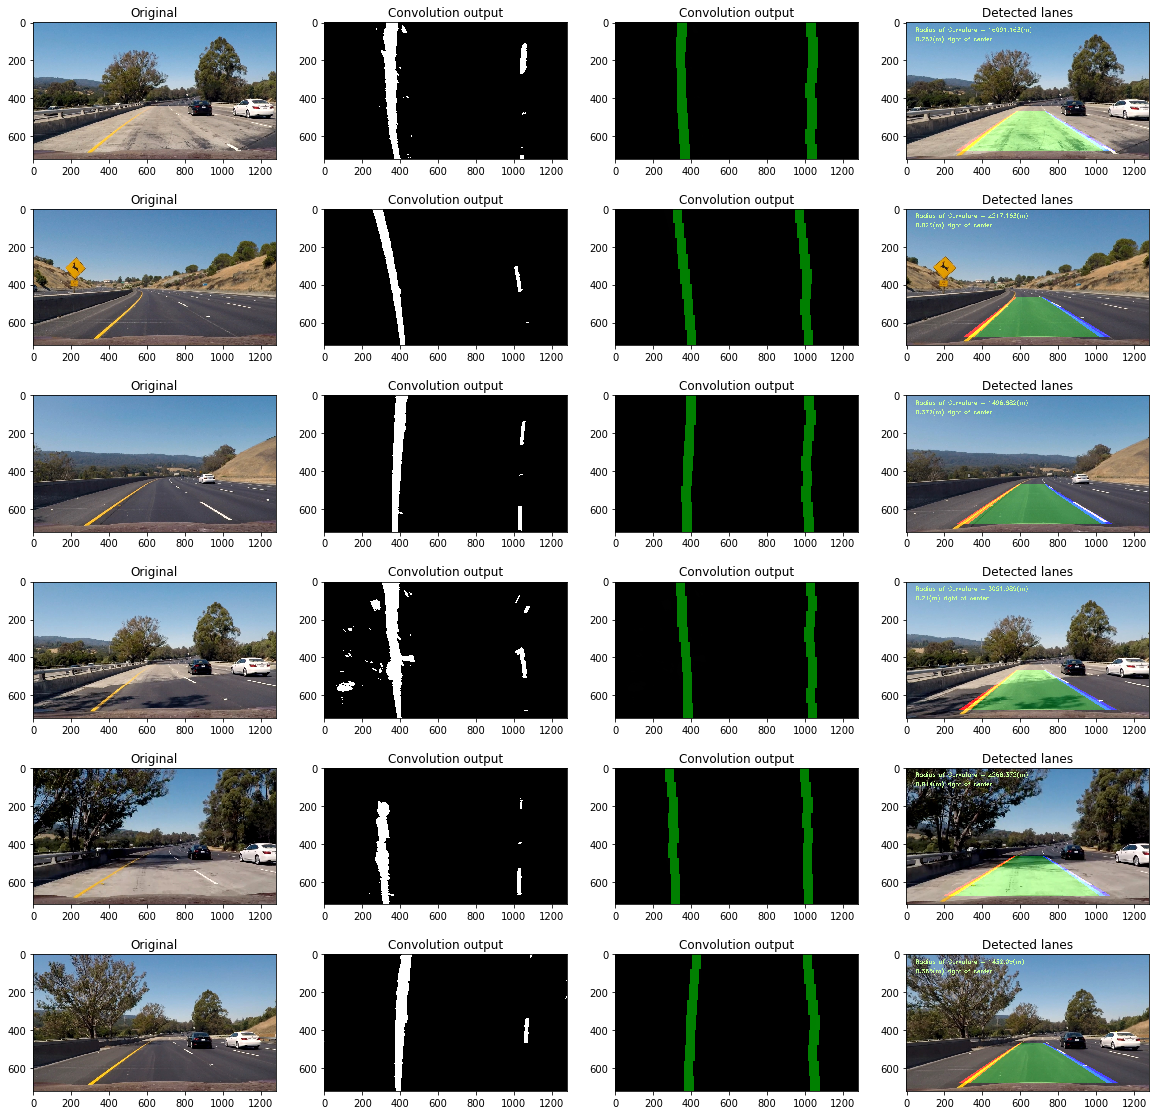

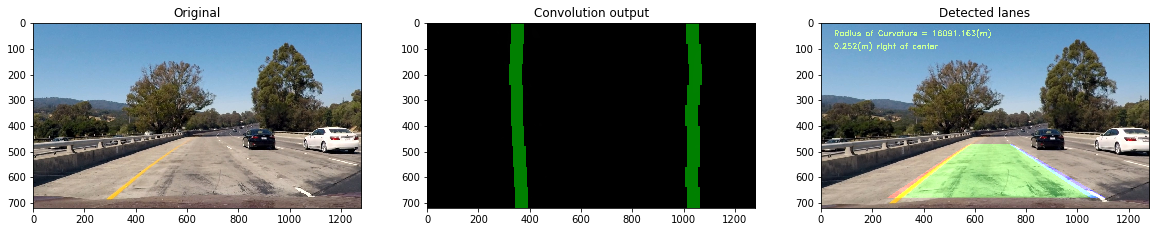

In [20]:
window_width = 50
window_height = 80
margin = 10

figure, axis = plt.subplots(6, 4, figsize=(20, 20))
axis = axis.ravel()
index = 0
for image_data in test_warped_and_thresholded:
    raw_image = image_data[0]
    raw_image_undistorted = image_data[1]
    raw_image_undistorted_warped = image_data[2]
    binary_warped = image_data[3]
    Mat = image_data[4]
    MatInv = image_data[5]
    result, convolution_image = single_image_convolution_search(window_width, window_height, margin, raw_image_undistorted, binary_warped, Mat, MatInv)
    
    axis[index].imshow(raw_image)
    axis[index].set_title("Original")
    
    axis[index+1].imshow(binary_warped,  cmap='gray')
    axis[index+1].set_title("Convolution output")
    
    axis[index+2].imshow(convolution_image)
    axis[index+2].set_title("Convolution output")
    
    axis[index+3].imshow(result)
    axis[index+3].set_title("Detected lanes")
    
    index += 4

figure.savefig("output_images/detected_lanes.png")

figure2, axis2 = plt.subplots(1, 3, figsize=(20, 5))
axis2 = axis2.ravel()

image_data = test_warped_and_thresholded[0]
raw_image = image_data[0]
raw_image_undistorted = image_data[1]
raw_image_undistorted_warped = image_data[2]
binary_warped = image_data[3]
Mat = image_data[4]
MatInv = image_data[5]

result, convolution_image = single_image_convolution_search(window_width, window_height, margin, raw_image_undistorted, binary_warped, Mat, MatInv)
axis2[0].imshow(raw_image)
axis2[0].set_title("Original")
axis2[1].imshow(convolution_image)
axis2[1].set_title("Convolution output")
axis2[2].imshow(result)
axis2[2].set_title("Detected lanes")

figure2.savefig("output_images/test_image_0_detected_lanes.png")

###  Tracker Class

In [21]:
class tracker(): 
    def __init__(self, Mywindow_width, Mywindow_height, Mymargin, Mysmooth_factor = 15):
        self.recent_centers = []
        self.window_width = Mywindow_width
        self.window_height = Mywindow_height
        self.margin = Mymargin
        self.smooth_factor = Mysmooth_factor
        self.frames = []
        self.total_differences = []
        
        self.current_left = None
        self.current_right = None
        
    def add_frame_data(self, frame_data): 
        self.frames.append(frame_data)
        
    def add_lane_diff(self, diff):
        self.total_differences.append(diff)
        
    def find_window_centroids(self, warped_image): 
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin
        
        window_centroids = []
        window = np.ones(window_width)
        
        l_sum = np.sum(warped_image[int(3*warped_image.shape[0]/4):, :int(warped_image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window, l_sum)) - (window_width/2)
        r_sum = np.sum(warped_image[int(5*warped_image.shape[0]/12):, int(warped_image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(warped_image.shape[1]/2)
        
        window_centroids.append((l_center, r_center))
        
        for level in range(1, (int)(warped_image.shape[0]/window_height)):
            # Convolve the window into the vertical slice of the image
            image_layer = np.sum(warped_image[int(warped_image.shape[0]-(level+1)*window_height):int(warped_image.shape[0]-level*window_height), :], axis=0)
            conv_signal = np.convolve(window, image_layer)
        
            # Find the best left centroid using past left center as a reference
            # Use window_width / 2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width / 2
            l_min_index = int(max(l_center + offset - margin, 0))
            l_max_index = int(min(l_center + offset + margin, warped_image.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
            
            # Find the best right centroid using past right center as a reference
            r_min_index = int(max(r_center + offset - margin, 0))
            r_max_index = int(min(r_center + offset + margin, warped_image.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
            
            # Add what we found for that layer
            window_centroids.append((l_center, r_center))
            
        self.recent_centers.append(window_centroids)
                
        # Return averaged values of the line centers, helps to keep the markers from jumping around too much
        return np.average(self.recent_centers[-self.smooth_factor:], axis=0)        

# Complete Pipeline

* Undistort image
* Apply color and gradient thresholding
* Apply perspective transform
* Identify lane lines using sliding window
* Measure radius of curvature
* Draw lane lines back onto original image
* Return updated image

In [22]:
# 1. Calibrate camera
calibration_images = glob.glob("camera_cal/calibration*.jpg")
objpoints, imgpoints = get_calibration_points(calibration_images)
calibration_image = mpimg.imread(calibration_images[0])

# 2. Get calibration matrices
mtx, dist = get_camera_calibration_matrices(calibration_image, objpoints, imgpoints)

# 3. Define processing pipeline    
def pipeline(image): 
    # 1. Process the image (undistort, thresholding, perspective transform)
    undistorted, warped_image, binary_warped, Mat, MatInv = process_image(image)
                
    # 2. Calculate window centroids
    window_centroids = curve_centers.find_window_centroids(binary_warped)
    
    # 3. Analyze window centroids and identify lanes
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        left_x_centroids = []
        right_x_centroids = [] 

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            left_x_centroids.append(window_centroids[level][0])
            right_x_centroids.append(window_centroids[level][1])

            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)

            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)),np.uint8) # making the original road pixels 3 color channels
        convolution_output_image = cv2.addWeighted(warpage, 1.0, template, 0.5, 0.0) # overlay the orignal road image with window results

     # If no window centers found, just display orginal road image
    else:
        convolution_output_image = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)

    yvals = range(0, binary_warped.shape[0])
    res_yvals = np.arange((binary_warped.shape[0] - (window_height) / 2), 0, -window_height)
    y_bottom = binary_warped.shape[0]
    
    left_line_fit = np.polyfit(res_yvals, left_x_centroids, 2)
    right_line_fit = np.polyfit(res_yvals, right_x_centroids, 2)
    
    if curve_centers.current_left is None and curve_centers.current_right is None:
        curve_centers.current_left = left_line_fit
        curve_centers.current_right = right_line_fit
    else:
        # Compute the distance between left and right
#         left_line_x = left_line_fit[0]*y_bottom**2 + left_line_fit[1]*y_bottom + left_line_fit[2]
#         right_line_x = right_line_fit[0]*y_bottom**2 + right_line_fit[1]*y_bottom + right_line_fit[2]
#         diff = abs(left_line_x - right_line_x)
        left_diff = abs(left_line_fit - curve_centers.current_left)
        if (left_diff[0] < 0.01 and left_diff[1] < 1.0 and left_diff[2] < 100.):
            curve_centers.current_left = left_line_fit
    
        right_diff = abs(right_line_fit - curve_centers.current_right)
        if (right_diff[0] < 0.01 and right_diff[1] < 1.0 and right_diff[2] < 100.):
            curve_centers.current_right = right_line_fit
            
        curve_centers.add_lane_diff([left_diff, right_diff])
            
#         print ("Diff: ", diff)
#         if 645 < diff and diff < 657:
#             print ("new line")
#             curve_centers.current_left = left_line_fit
#             curve_centers.current_right = right_line_fit
#         else:
#             print ("Removing last center")
#             curve_centers.recent_centers = curve_centers.recent_centers[:-1]
#             curve_centers = np.average(self.recent_centers[-self.smooth_factor:], axis=0)
    
    current_left_fit = curve_centers.current_left
    current_right_fit = curve_centers.current_right
    
    current_left_fit_x = current_left_fit[0]*yvals*yvals + current_left_fit[1]*yvals + current_left_fit[2]
    current_left_fit_x = np.array(current_left_fit_x, np.int32)
    
    current_right_fit_x = current_right_fit[0]*yvals*yvals + current_right_fit[1]*yvals + current_right_fit[2]
    current_right_fit_x = np.array(current_right_fit_x, np.int32)
    
#     # Extrapolate x and y poly-fit lines
#     left_line_fit = np.polyfit(res_yvals, left_x_centroids, 2)
#     left_line_fit_x = left_line_fit[0]*yvals*yvals + left_line_fit[1]*yvals + left_line_fit[2]
#     left_line_fit_x = np.array(left_line_fit_x, np.int32)

#     right_line_fit = np.polyfit(res_yvals, right_x_centroids, 2)
#     right_line_fit_x = right_line_fit[0]*yvals*yvals + right_line_fit[1]*yvals + right_line_fit[2]
#     right_line_fit_x = np.array(right_line_fit_x, np.int32)
        
    left_lane = np.array(list(zip(np.concatenate((current_left_fit_x-window_width/2, current_left_fit_x[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0) )), np.int32)
    right_lane = np.array(list(zip(np.concatenate((current_right_fit_x-window_width/2, current_right_fit_x[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0) )), np.int32)
#     middle_marker = np.array(list(zip(np.concatenate((left_line_fit_x+window_width/2, right_line_fit_x[::-1]+window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis=0) )), np.int32)

    # Draw lane lines
    road = np.zeros_like(undistorted)
    cv2.fillPoly(road, [left_lane], color=[255, 0, 0])
    cv2.fillPoly(road, [right_lane], color=[0, 0, 255])
    road_warped = cv2.warpPerspective(road, MatInv, (undistorted.shape[1], undistorted.shape[0]), flags=cv2.INTER_LINEAR)
    lanes = cv2.addWeighted(undistorted, 1.0, road_warped, 1.0, 0.0)
    
    # Draw lane fill
    full_road = draw_lanes(lanes, binary_warped, MatInv, current_left_fit, current_right_fit)

    # Calculate radius of curvature
    left_curve_rad, right_curve_rad = radius_of_curvature_2(binary_warped, current_left_fit_x, current_right_fit_x)
    average_curve_rad = left_curve_rad + right_curve_rad / 2
    
    # Calculate distance from center
    distance_from_center_in_meters = distance_from_center(binary_warped, current_left_fit_x, current_right_fit_x)

    # Draw radius of curvature and distance from center
    result = draw_road_data(full_road, average_curve_rad, distance_from_center_in_meters)  
    
    curve_centers.add_frame_data([image, undistorted, warped_image, binary_warped, convolution_output_image, full_road])
    
    return result

# Video Playback

### Project Video

In [23]:
# Create left and right Line() instances
window_width = 50
window_height = 80
margin = 10
curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin=margin, Mysmooth_factor=12)
project_video_outname = 'project_video_with_lanes.mp4'
project_video = VideoFileClip("project_video.mp4")
project_video_updated = project_video.fl_image(pipeline) # -- pipeline for single image
%time project_video_updated.write_videofile(project_video_outname, audio=False)

[MoviePy] >>>> Building video project_video_with_lanes.mp4
[MoviePy] Writing video project_video_with_lanes.mp4


100%|█████████▉| 1260/1261 [03:15<00:00,  6.12it/s]    | 1/1261 [00:00<02:54,  7.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_lanes.mp4 

CPU times: user 5min 38s, sys: 39.6 s, total: 6min 17s
Wall time: 3min 16s


In [24]:
project_video_outname = 'project_video_with_lanes.mp4'

HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(project_video_outname))

### Frame by Frame Analysis

In [ ]:
# image = curve_centers.frames[550][0]
# plt.imshow(image)

print (len(curve_centers.frames))
print (len(curve_centers.total_differences))

figure, axis = plt.subplots(20, 5, figsize=(20, 20))
axis = axis.ravel()
index = 0
for i in range(0, 20):
    frame_i = curve_centers.frames[i]
    image = frame_i[0]
    undistorted = frame_i[1]
    warped = frame_i[2]
    binary_warped = frame_i[3]
    identified_lanes = frame_i[4]
    mapped_lanes = frame_i[5]
    axis[index].imshow(undistorted)
    axis[index+1].imshow(warped)
    axis[index+2].imshow(binary_warped, cmap='gray')
    axis[index+3].imshow(identified_lanes)
    axis[index+4].imshow(mapped_lanes)
    index += 5
#     cv2.imwrite("test_images/anomaly" + str(i) + ".jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
# figure.savefig("output_images/frame_by_frame_analysis_gray_pavement_anomaly.png")

### Challenge Video 1

In [ ]:
# Create left and right Line() instances
window_width = 50
window_height = 80
margin = 30
curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin=margin, Mysmooth_factor=15)

challenge_video_one_outname = "challenge_video_1_with_lanes.mp4"
challenge_video_one = VideoFileClip("test_videos/challenge_video_1.mp4")
challenge_video_one_updated = challenge_video_one.fl_image(pipeline) # -- pipeline for single image
%time challenge_video_one_updated.write_videofile(challenge_video_one_outname, audio=False)

In [ ]:
HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(challenge_video_one_outname))

### Challenge Video 2

In [ ]:
# Create left and right Line() instances
window_width = 50
window_height = 80
margin = 30
curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin=margin, Mysmooth_factor=15)

challenge_video_two_outname = 'test_videos/challenge_video_2_with_lanes.mp4'
challenge_video_two = VideoFileClip("test_videos/challenge_video_2.mp4")
challenge_video_two_updated = challenge_video_two.fl_image(pipeline) # -- pipeline for single image
%time challenge_video_two_updated.write_videofile(challenge_video_two_outname, audio=False)

In [ ]:
HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(challenge_video_two_outname))

### Harder Challenge Video 

In [ ]:
# Create left and right Line() instances
window_width = 50
window_height = 80
margin = 30
curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin=margin, Mysmooth_factor=15)

harder_challenge_video_outname = 'test_videos/harder_challenge_video_with_lanes.mp4'
harder_challenge_video = VideoFileClip("test_videos/harder_challenge_video.mp4")
harder_challenge_video_updated = harder_challenge_video.fl_image(pipeline) # -- pipeline for single image
%time harder_challenge_video_updated.write_videofile(harder_challenge_video_outname, audio=False)

In [ ]:
HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(harder_challenge_video_outname))

In [ ]:
# Extrapolate x and y poly-fit lines
left_line_fit = np.polyfit(res_yvals, left_x_centroids, 2)
left_line_fit_x = left_line_fit[0]*yvals*yvals + left_line_fit[1]*yvals + left_line_fit[2]
left_line_fit_x = np.array(left_line_fit_x, np.int32)

right_line_fit = np.polyfit(res_yvals, right_x_centroids, 2)
right_line_fit_x = right_line_fit[0]*yvals*yvals + right_line_fit[1]*yvals + right_line_fit[2]
right_line_fit_x = np.array(right_line_fit_x, np.int32)

